In [1]:
# import libraries
import numpy as np
import pandas as pd
import datasets 
from datasets import Features, Image, load_dataset, load_dataset_builder, config, concatenate_datasets
import matplotlib.pyplot as plt
import seaborn as sns
import os

import shutil
import pathlib
import PIL
from PIL import Image
import requests
from io import BytesIO
import wikipedia

import torch
import torchvision
from torchvision.transforms import v2, ToTensor, Lambda
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, Subset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix

Matplotlib created a temporary cache directory at /tmp/matplotlib-v3pyo120 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# check for GPU and create the device object
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


## Data Load and Processing

In [3]:
# get data (from https://huggingface.co/datasets/YakupAkdin/instrument-images/tree/main)
dataset = load_dataset("YakupAkdin/instrument-images", split='train').with_format('torch', device=device)

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
# define our labels
label_values = {
    0: 'harp',
    1: 'baglama',
    2: 'electric guitar',
    3: 'acoustic guitar',
    4: 'kanun',
    5: 'violin',
    6: 'kemence',
    7: 'mandolin',
    8: 'oud',
    9: 'yayli tambur'}

inverted_labels = {v: k for k, v in label_values.items()}

In [5]:
# create a pandas copy for easier PIL
df_clone = dataset.to_pandas()
df_clone = df_clone.assign(
    desc = df_clone.label.map(label_values),
    image = df_clone.image.apply(lambda x: x['path']))
df_clone.head()

image  label  desc
0  /workspace/hf_cache/downloads/c1788b27609c6ad9...      0  harp
1  /workspace/hf_cache/downloads/8f8cdb21c6698ee6...      0  harp
2  /workspace/hf_cache/downloads/41f7f4b3f28c4ede...      0  harp
3  /workspace/hf_cache/downloads/4bce77de0a7870be...      0  harp
4  /workspace/hf_cache/downloads/e5502c68bcbbc862...      0  harp


 0 : harp


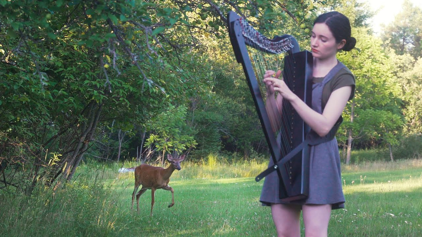


 3 : acoustic guitar


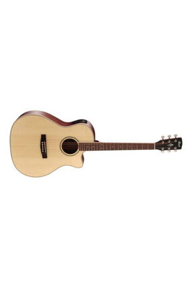


 6 : kemence


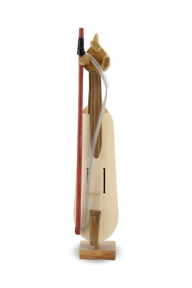


 9 : yayli tambur


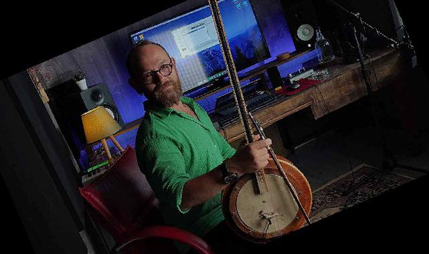

In [6]:
# view some images and labels
def img_check(i, scale):
    print('\n', df_clone.label[i],':',df_clone.desc[i])
    img = PIL.Image.open(df_clone.image[i])
    img = img.resize((int(img.size[0]/(100/scale)), int(img.size[1]/(100/scale))))
    img.show()

img_check(0, 33)
img_check(333, 67)
img_check(666, 67)
img_check(999, 67)

#### Tensor manipulation for mixed image types

In [7]:
# isolate RGB images for pre processing
dataset_RGB = dataset.filter(lambda x: x['image'].dim() == 3)
len(dataset_RGB)

989

In [8]:
# the RGB images are [H,W,3] and PyTorch needs them as [3,H,W]
# included [:3, :, :] slice to adjust any RGBA images to RGB
print(dataset_RGB[0]['image'].shape)

# permute the tensors
def permute_images(batch):
    # Apply the permute operation to each tensor in the batch
    batch['image'] = [img.permute(2, 0, 1)[:3, :, :] for img in batch['image']]
    return batch

dataset_RGB = dataset_RGB.map(permute_images, batched=True, batch_size=10)

dataset_RGB[0]['image'].shape

torch.Size([720, 1280, 3])


torch.Size([3, 720, 1280])

In [9]:
# isolate greyscale images for pre processing
dataset_greyscale = dataset.filter(lambda x: x['image'].dim() == 2)
len(dataset_greyscale)

11

In [10]:
# convert to RGB
print(dataset_greyscale[0]['image'].shape)

def grayscale_to_rgb(item):
    item['image'] = item['image'].unsqueeze(0).repeat(3, 1, 1)
    return item

dataset_greyscale = dataset_greyscale.map(grayscale_to_rgb)
print(dataset_greyscale[0]['image'].shape)

torch.Size([849, 900])
torch.Size([3, 849, 900])


In [11]:
# concatenate both reformatted RGB datasets
dataset = concatenate_datasets([dataset_RGB, dataset_greyscale])

#### Transform image tensors for model compatibility

In [12]:
# confirming 0-255 scaling and int dtype of image tensors
sample_image = dataset[0]['image']

print('Tensor dtype:', sample_image.dtype)
print("Sample values:", sample_image.flatten()[:10])
print("Max value:", sample_image.max().item())
print("Min value:", sample_image.min().item())

Tensor dtype: torch.int64
Sample values: tensor([40, 39, 41, 41, 41, 44, 48, 53, 54, 52], device='cuda:0')
Max value: 255
Min value: 0


In [13]:
# compose transformation function
def scale_tensor(tensor):
    return tensor.float() / 255

basic_transform = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True), # resize for model requirements
    v2.RandomHorizontalFlip(p=0.5),
    scale_tensor, # converts to [0, 1] float dtype
    v2.Lambda(lambda x: torch.clamp(x, 0, 1)),  # clamp max values to 1 before normalization
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # required normalization for resnet
])

# application function for transforms
def apply_transform(example):
    # Apply the transformation to the 'image' field
    example['image'] = [basic_transform(img) for img in example['image']]
    return example

# apply transforms
dataset = dataset.map(apply_transform, batched=True, batch_size=100)

In [14]:
# quick check on the transform
sample_image = dataset[0]['image']

print('Tensor dtype:', sample_image.dtype)
print('Sample values:', sample_image.flatten()[0:10])
print('Max value:', sample_image.max().item())
print('Min value:', sample_image.min().item())

Tensor dtype: torch.float32
Sample values: tensor([-0.9020, -0.9020, -0.6794, -0.7650, -0.9363, -0.8678, -0.4568, -0.2513,
        -0.2684,  0.0912], device='cuda:0')
Max value: 2.517995834350586
Min value: -1.7925336360931396


#### Examine Dataset/Model Compatibility Before Training

In [15]:
# are all tensors shape [3, 224, 224]?
correct_tensor_shape = 0

for i in range(len(dataset)):
    if dataset[i]['image'].shape != torch.Size([3, 224, 224]):
        print(f"Image at index {i} has incorrect shape: {image.shape}")
    else:
        correct_tensor_shape += 1

print(correct_tensor_shape)

1000



 2 : electric guitar


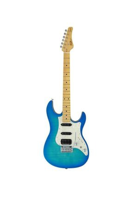


 2 : electric guitar


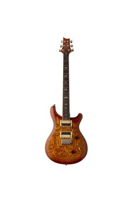


 2 : electric guitar


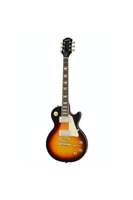


 2 : electric guitar


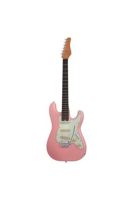


 2 : electric guitar


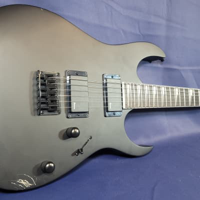


 7 : mandolin


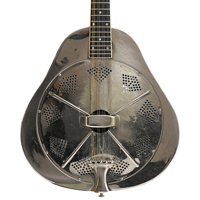


 7 : mandolin


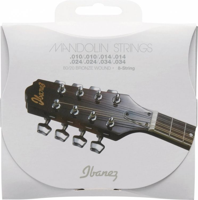


 7 : mandolin


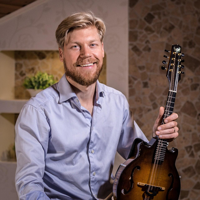


 7 : mandolin


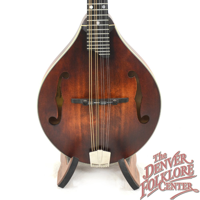


 7 : mandolin


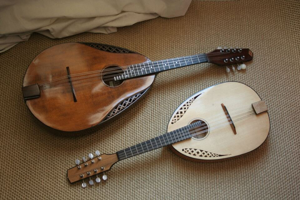


 8 : oud


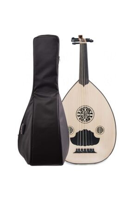


 8 : oud


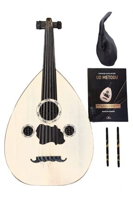


 8 : oud


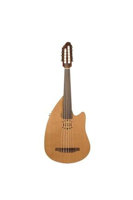


 8 : oud


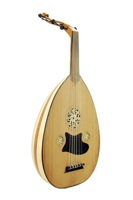


 8 : oud


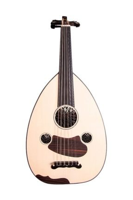


 4 : kanun


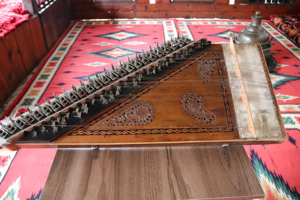


 4 : kanun


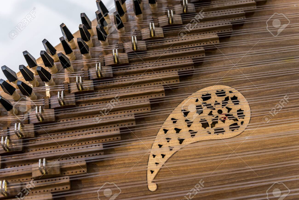


 4 : kanun


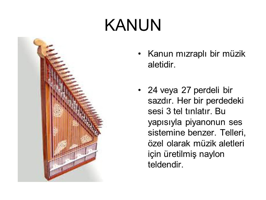


 4 : kanun


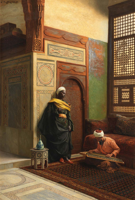


 4 : kanun


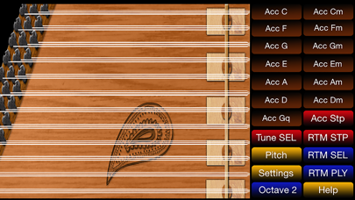

In [17]:
# are labels and images consistent?

#function to print a random x images/labels for a given instrument
def check_instrument(instrument, sample_size):    
    check = df_clone.loc[df_clone.desc == instrument].sample(sample_size).reset_index()
    for row in range(sample_size):
        image = check.image[row]
        img = PIL.Image.open(image).convert('RGB')
        img = img.resize((max(1, int(img.size[0] * 200 / img.size[1])), 200))
        print('\n', check.label[row],':', check.desc[row])
        img.show()        

# check some images
check_instrument('electric guitar', 5)
check_instrument('mandolin', 5)
check_instrument('oud', 5)
check_instrument('kanun', 5)

## Model Fine Tuning

#### Dataloader setup

In [18]:
# split test/train
dataset = dataset.train_test_split(test_size=0.2, seed=1, stratify_by_column="label")

In [19]:
batch_size = 4

trainloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=False, num_workers=0)
testloader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, num_workers=0)

#### Replacing tutorial model with pre-trained [resnet 18](https://arxiv.org/abs/1512.03385)

In [20]:
# import model to our Docker workspace
os.environ['TORCH_HOME'] = os.getcwd()

# import
from torchvision.models import resnet18, ResNet18_Weights

In [42]:
# load model with weights (only one option)
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=ResNet18_Weights.IMAGENET1K_V1)

Using cache found in /workspace/hub/pytorch_vision_v0.10.0


In [43]:
# modifying the final layer to suit our 10 classes
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)

# freeze layers that aren't final fully connected layer
for name, param in model.named_parameters():
    if 'fc' not in name:
        param.requires_grad=False

# model to GPU and set to eval
model = model.to(device)
model = model.eval()

# save the model
torch.save(model.state_dict(), '/workspace/resnet18_reset_state.pth')

In [25]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Fine Tuning the Model

In [26]:
# create iterator
dataiter = iter(testloader)

In [27]:
# Define loss function: Classification Cross-Entropy loss and SGD with momentum.

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#### Training loop with logging for loss, accuracy, and model state

In [44]:
training_log = {'epoch': [], 'loss' : [], 'train_acc': [], 'test_acc': [], 'model_state': []}

def train_model(modelname, start_epoch, end_epoch, model, trainloader, testloader, optimizer, criterion, training_log):

    for epoch in range(start_epoch, end_epoch): 
    
        # set baseline for epoch
        running_loss = 0.0
        train_labels, train_pred = [], []
        model.train()

        # loop through each batch of the training dataloader
        for i, data in enumerate(trainloader, 0):
            inputs = data['image']
            labels = data['label']
        
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # catalog training results
            _, predicted = torch.max(outputs, 1)
            train_labels.append(labels.cpu())
            train_pred.append(predicted.cpu())
        
            # print statistics
            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                training_log['loss'].append(running_loss/200) # log the epoch loss before resetting it
                running_loss = 0.0

        # training results lists into tensors and calculate training accuracy
        train_labels = torch.cat(train_labels)
        train_pred = torch.cat(train_pred)
        train_acc = (train_pred == train_labels).sum().item() / train_labels.size(0)

        # test model after each training epoch
        test_labels, test_pred = [], []
        model.eval()
    
        for i, data in enumerate(testloader, 0):
            inputs = data['image']
            labels = data['label']
            outputs = model(inputs)

            # catalog test results
            _, predicted = torch.max(outputs, 1)
            test_labels.append(labels.cpu())
            test_pred.append(predicted.cpu())

        # test results lists into tensors and calculate test accuracy
        test_labels = torch.cat(test_labels)
        test_pred = torch.cat(test_pred)    
        test_acc = (test_pred == test_labels).sum().item() / test_labels.size(0)
    
        # add epoch details to training log
        training_log['epoch'].append(epoch) # epoch number
        training_log['train_acc'].append(train_acc) # training accuracy
        training_log['test_acc'].append(test_acc) # test accuracy

        # save the model
        cwd = os.getcwd()
        filename = f'{modelname}_state_epoch_{epoch}.pth'
        path = os.path.join(cwd, filename)
        torch.save(model.state_dict(), path)
        training_log['model_state'].append(path)
        print(f'epoch {epoch} complete')

In [30]:
# test one loop of the fine tuning function
train_model('resnet18', 0, 1, model, trainloader, testloader, optimizer, criterion, training_log)
# view the training results as a dataframe
training_results = pd.DataFrame.from_dict(training_log)
training_results.head()

epoch      loss  train_acc  test_acc                            model_state
0      0  1.935972     0.3225      0.68  /workspace/resnet18_state_epoch_0.pth

In [33]:
# test one loop of the fine tuning function
train_model('resnet18', 1, 21, model, trainloader, testloader, optimizer, criterion, training_log)
# view the training results as a dataframe
training_results = pd.DataFrame.from_dict(training_log)

In [32]:
training_results

epoch      loss  train_acc  test_acc  \
0       0  1.935972    0.32250     0.680   
1       1  1.215795    0.60750     0.765   
2       2  0.972614    0.68875     0.765   
3       3  0.840407    0.74875     0.765   
4       4  0.751976    0.78000     0.745   
5       5  0.685581    0.80000     0.750   
6       6  0.632169    0.82375     0.750   
7       7  0.587386    0.85125     0.750   
8       8  0.548885    0.86375     0.750   
9       9  0.515251    0.87625     0.750   
10     10  0.485527    0.88375     0.760   
11     11  0.458993    0.89625     0.760   
12     12  0.435066    0.90250     0.760   
13     13  0.413275    0.90750     0.760   
14     14  0.393253    0.91625     0.760   
15     15  0.374727    0.92000     0.760   
16     16  0.357502    0.92875     0.755   
17     17  0.341434    0.93875     0.760   
18     18  0.326416    0.94250     0.765   
19     19  0.312356    0.94875     0.770   
20     20  0.299180    0.95750     0.770   

                               model_state  
0    /workspace/resnet18_state_epoch_0.pth  
1    /workspace/resnet18_state_epoch_1.pth  
2    /workspace/resnet18_state_epoch_2.pth  
3    /workspace/resnet18_state_epoch_3.pth  
4    /workspace/resnet18_state_epoch_4.pth  
5    /workspace/resnet18_state_epoch_5.pth  
6    /workspace/resnet18_state_epoch_6.pth  
7    /workspace/resnet18_state_epoch_7.pth  
8    /workspace/resnet18_state_epoch_8.pth  
9    /workspace/resnet18_state_epoch_9.pth  
10  /workspace/resnet18_state_epoch_10.pth  
11  /workspace/resnet18_state_epoch_11.pth  
12  /workspace/resnet18_state_epoch_12.pth  
13  /workspace/resnet18_state_epoch_13.pth  
14  /workspace/resnet18_state_epoch_14.pth  
15  /workspace/resnet18_state_epoch_15.pth  
16  /workspace/resnet18_state_epoch_16.pth  
17  /workspace/resnet18_state_epoch_17.pth  
18  /workspace/resnet18_state_epoch_18.pth  
19  /workspace/resnet18_state_epoch_19.pth  
20  /workspace/resnet18_state_epoch_20.pth

### Lower Learning Rate

In [45]:
# try a lower learning rate

# setup: reset model state and choose new learning rate
model.load_state_dict(torch.load('/workspace/resnet18_reset_state.pth', map_location=device))
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [46]:
# test one loop of the fine tuning function
train_model('resnet18_lower_lr', 0, 1, model, trainloader, testloader, optimizer, criterion, training_log)
# view the training results as a dataframe
training_results = pd.DataFrame.from_dict(training_log)
training_results.head()

epoch 0 complete


epoch      loss  train_acc  test_acc  \
0      0  2.262464    0.17125     0.255   

                                      model_state  
0  /workspace/resnet18_lower_lr_state_epoch_0.pth

In [47]:
# test one loop of the fine tuning function
train_model('resnet18_lower_lr', 1, 21, model, trainloader, testloader, optimizer, criterion, training_log)
# view the training results as a dataframe
training_results = pd.DataFrame.from_dict(training_log)

epoch 1 complete
epoch 2 complete
epoch 3 complete
epoch 4 complete
epoch 5 complete
epoch 6 complete
epoch 7 complete
epoch 8 complete
epoch 9 complete
epoch 10 complete
epoch 11 complete
epoch 12 complete
epoch 13 complete
epoch 14 complete
epoch 15 complete
epoch 16 complete
epoch 17 complete
epoch 18 complete
epoch 19 complete
epoch 20 complete


In [49]:
training_results

epoch      loss  train_acc  test_acc  \
0       0  2.262464    0.17125     0.255   
1       1  2.024787    0.31750     0.430   
2       2  1.842527    0.43875     0.555   
3       3  1.694924    0.53250     0.600   
4       4  1.574261    0.59625     0.650   
5       5  1.474530    0.63750     0.675   
6       6  1.391135    0.66875     0.690   
7       7  1.320579    0.69375     0.715   
8       8  1.260205    0.71000     0.735   
9       9  1.207980    0.72250     0.740   
10     10  1.162341    0.72875     0.740   
11     11  1.122079    0.73875     0.745   
12     12  1.086249    0.75250     0.750   
13     13  1.054108    0.75625     0.755   
14     14  1.025063    0.76625     0.760   
15     15  0.998641    0.77250     0.765   
16     16  0.974458    0.77500     0.765   
17     17  0.952203    0.78125     0.765   
18     18  0.931619    0.78250     0.765   
19     19  0.912492    0.78750     0.770   
20     20  0.894646    0.79125     0.770   

                                        model_state  
0    /workspace/resnet18_lower_lr_state_epoch_0.pth  
1    /workspace/resnet18_lower_lr_state_epoch_1.pth  
2    /workspace/resnet18_lower_lr_state_epoch_2.pth  
3    /workspace/resnet18_lower_lr_state_epoch_3.pth  
4    /workspace/resnet18_lower_lr_state_epoch_4.pth  
5    /workspace/resnet18_lower_lr_state_epoch_5.pth  
6    /workspace/resnet18_lower_lr_state_epoch_6.pth  
7    /workspace/resnet18_lower_lr_state_epoch_7.pth  
8    /workspace/resnet18_lower_lr_state_epoch_8.pth  
9    /workspace/resnet18_lower_lr_state_epoch_9.pth  
10  /workspace/resnet18_lower_lr_state_epoch_10.pth  
11  /workspace/resnet18_lower_lr_state_epoch_11.pth  
12  /workspace/resnet18_lower_lr_state_epoch_12.pth  
13  /workspace/resnet18_lower_lr_state_epoch_13.pth  
14  /workspace/resnet18_lower_lr_state_epoch_14.pth  
15  /workspace/resnet18_lower_lr_state_epoch_15.pth  
16  /workspace/resnet18_lower_lr_state_epoch_16.pth  
17  /workspace/resnet18_lower_lr_state_epoch_17.pth  
18  /workspace/resnet18_lower_lr_state_epoch_18.pth  
19  /workspace/resnet18_lower_lr_state_epoch_19.pth  
20  /workspace/resnet18_lower_lr_state_epoch_20.pth

In [50]:
train_model('resnet18_lower_lr', 21, 31, model, trainloader, testloader, optimizer, criterion, training_log)

epoch 21 complete
epoch 22 complete
epoch 23 complete
epoch 24 complete
epoch 25 complete
epoch 26 complete
epoch 27 complete
epoch 28 complete
epoch 29 complete
epoch 30 complete


In [51]:
# view the training results as a dataframe
training_results = pd.DataFrame.from_dict(training_log)
training_results

epoch      loss  train_acc  test_acc  \
0       0  2.262464    0.17125     0.255   
1       1  2.024787    0.31750     0.430   
2       2  1.842527    0.43875     0.555   
3       3  1.694924    0.53250     0.600   
4       4  1.574261    0.59625     0.650   
5       5  1.474530    0.63750     0.675   
6       6  1.391135    0.66875     0.690   
7       7  1.320579    0.69375     0.715   
8       8  1.260205    0.71000     0.735   
9       9  1.207980    0.72250     0.740   
10     10  1.162341    0.72875     0.740   
11     11  1.122079    0.73875     0.745   
12     12  1.086249    0.75250     0.750   
13     13  1.054108    0.75625     0.755   
14     14  1.025063    0.76625     0.760   
15     15  0.998641    0.77250     0.765   
16     16  0.974458    0.77500     0.765   
17     17  0.952203    0.78125     0.765   
18     18  0.931619    0.78250     0.765   
19     19  0.912492    0.78750     0.770   
20     20  0.894646    0.79125     0.770   
21     21  0.877931    0.79375     0.765   
22     22  0.862221    0.79500     0.765   
23     23  0.847408    0.79875     0.765   
24     24  0.833401    0.80125     0.765   
25     25  0.820120    0.80500     0.760   
26     26  0.807495    0.80500     0.760   
27     27  0.795469    0.80875     0.760   
28     28  0.783987    0.81250     0.760   
29     29  0.773005    0.81500     0.760   
30     30  0.762481    0.81750     0.760   

                                        model_state  
0    /workspace/resnet18_lower_lr_state_epoch_0.pth  
1    /workspace/resnet18_lower_lr_state_epoch_1.pth  
2    /workspace/resnet18_lower_lr_state_epoch_2.pth  
3    /workspace/resnet18_lower_lr_state_epoch_3.pth  
4    /workspace/resnet18_lower_lr_state_epoch_4.pth  
5    /workspace/resnet18_lower_lr_state_epoch_5.pth  
6    /workspace/resnet18_lower_lr_state_epoch_6.pth  
7    /workspace/resnet18_lower_lr_state_epoch_7.pth  
8    /workspace/resnet18_lower_lr_state_epoch_8.pth  
9    /workspace/resnet18_lower_lr_state_epoch_9.pth  
10  /workspace/resnet18_lower_lr_state_epoch_10.pth  
11  /workspace/resnet18_lower_lr_state_epoch_11.pth  
12  /workspace/resnet18_lower_lr_state_epoch_12.pth  
13  /workspace/resnet18_lower_lr_state_epoch_13.pth  
14  /workspace/resnet18_lower_lr_state_epoch_14.pth  
15  /workspace/resnet18_lower_lr_state_epoch_15.pth  
16  /workspace/resnet18_lower_lr_state_epoch_16.pth  
17  /workspace/resnet18_lower_lr_state_epoch_17.pth  
18  /workspace/resnet18_lower_lr_state_epoch_18.pth  
19  /workspace/resnet18_lower_lr_state_epoch_19.pth  
20  /workspace/resnet18_lower_lr_state_epoch_20.pth  
21  /workspace/resnet18_lower_lr_state_epoch_21.pth  
22  /workspace/resnet18_lower_lr_state_epoch_22.pth  
23  /workspace/resnet18_lower_lr_state_epoch_23.pth  
24  /workspace/resnet18_lower_lr_state_epoch_24.pth  
25  /workspace/resnet18_lower_lr_state_epoch_25.pth  
26  /workspace/resnet18_lower_lr_state_epoch_26.pth  
27  /workspace/resnet18_lower_lr_state_epoch_27.pth  
28  /workspace/resnet18_lower_lr_state_epoch_28.pth  
29  /workspace/resnet18_lower_lr_state_epoch_29.pth  
30  /workspace/resnet18_lower_lr_state_epoch_30.pth

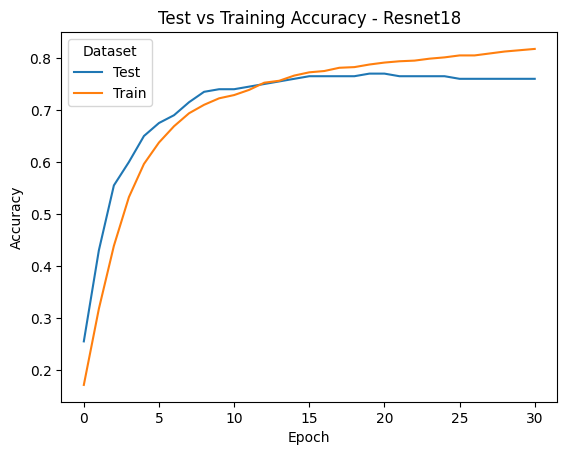

In [53]:
# plot to show the test and training accuracy over time
longform_results = pd.melt(training_results, id_vars=['epoch'], value_vars=['test_acc', 'train_acc'], var_name='Dataset', value_name='accuracy')

label_map = {'test_acc': 'Test', 'train_acc': 'Train'}
longform_results['Dataset'] = longform_results['Dataset'].replace(label_map)

# sns.lineplot(data=training_results, x='epoch', y='loss')
sns.lineplot(data=longform_results, x='epoch', y='accuracy', hue='Dataset')

plt.title('Test vs Training Accuracy - Resnet18')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

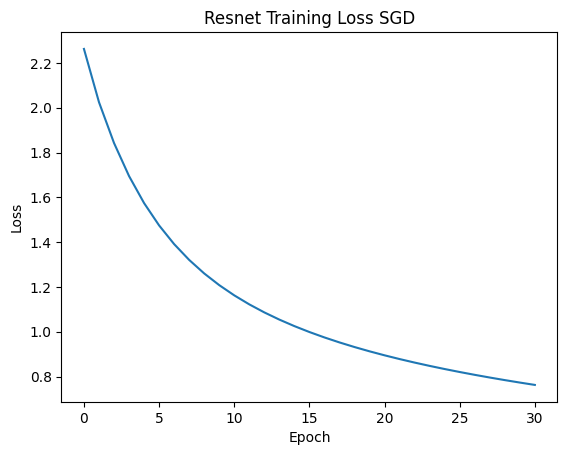

In [54]:
# plot to show the test and training accuracy over time
longform_results = pd.melt(training_results, id_vars=['epoch'], value_vars=['test_acc', 'train_acc'], var_name='Dataset', value_name='accuracy')

label_map = {'test_acc': 'Test', 'train_acc': 'Train'}
longform_results['Dataset'] = longform_results['Dataset'].replace(label_map)

sns.lineplot(data=training_results, x='epoch', y='loss')

plt.title('Resnet Training Loss SGD')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### Resnet18 is overfitting quickly because the dataset is small
Solutions & next steps to explore:<br>
- image augmentation
- cross validation
- using a shallower model

#### Evaluating the fine tuned model

In [57]:
# load the state that was most accurate on test data before we started overfitting (epoch 19)
model.load_state_dict(torch.load('/workspace/resnet18_lower_lr_state_epoch_19.pth', map_location=device))

<All keys matched successfully>

In [58]:
# set to eval mode
model.eval();

In [59]:
# creating a confusion matrix
true_label = []
pred_label = []

# with torch.no_grad():
for batch in testloader:
    images = batch['image']
    labels = batch['label']
    with torch.no_grad():
        output = model(images)
    _, predicted = torch.max(output, 1)

    true_label.extend(labels.tolist())
    pred_label.extend(predicted.tolist())

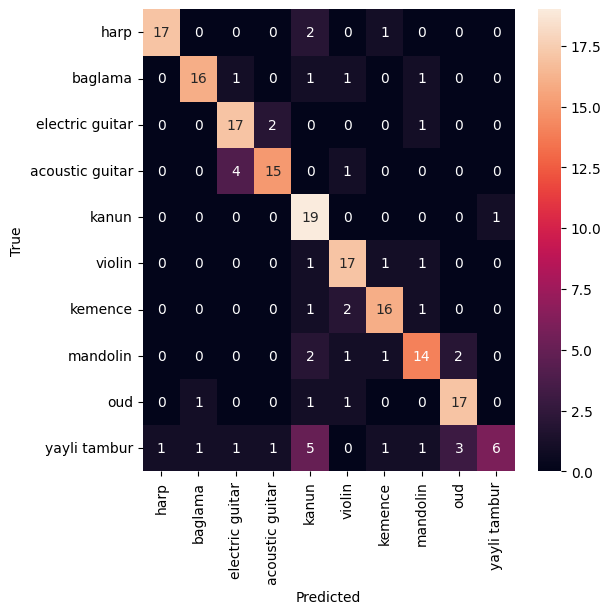

In [60]:
# generate confusion matrix
cm = confusion_matrix(true_label, pred_label)

# get labels from dictionary
label_keys = sorted(label_values.keys())  
label_list = [label_values[key] for key in label_keys]

# plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Notes:
- Only yayli tambur and mandolin are below 75% accuracy
- Guitar types confused for each other - they can often be very similar in shape, and the training data for both are "floating in space"
- Better data would include guitar pictures with varied backgrounds and orientations
- Yayli tambur was misclassified as nearly every other instrument (image 935 and 964 have other instruments in them, some are "floating in space" like guitars)

In [61]:
# return to our image viewing function

#function to print a random x images/labels for a given instrument
def check_instrument(instrument, sample_size):    
    check = df_clone.loc[df_clone.desc == instrument].sample(sample_size).reset_index(names = 'image_num')
    for row in range(sample_size):
        image = check.image[row]
        img = PIL.Image.open(image).convert('RGB')
        img = img.resize((max(1, int(img.size[0] * 200 / img.size[1])), 200))
        print('image ', check.image_num[row],':', check.desc[row])
        img.show()

image  457 : kanun


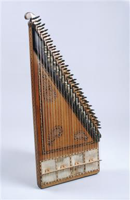

image  453 : kanun


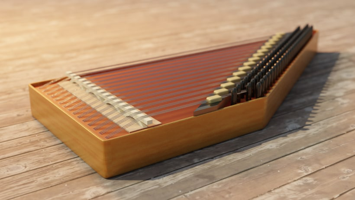

image  447 : kanun


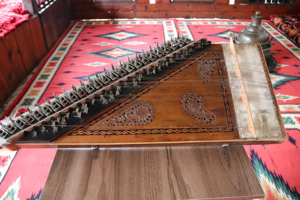

image  494 : kanun


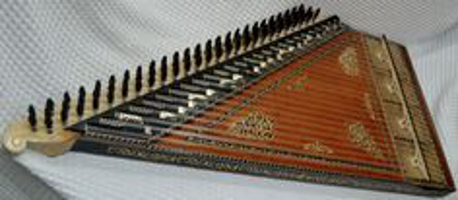

image  446 : kanun


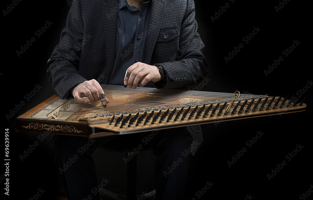

image  905 : yayli tambur


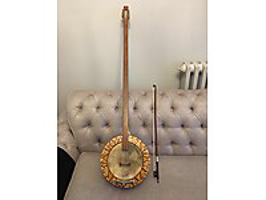

image  929 : yayli tambur


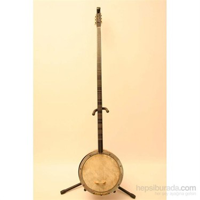

image  981 : yayli tambur


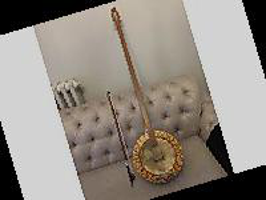

image  935 : yayli tambur


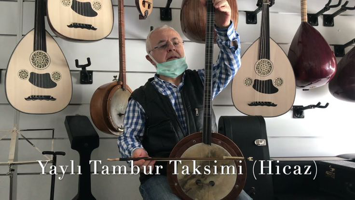

image  911 : yayli tambur


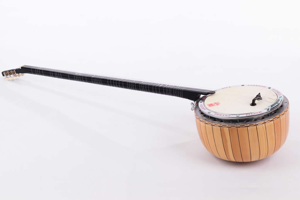

image  950 : yayli tambur


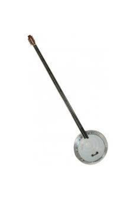

image  971 : yayli tambur


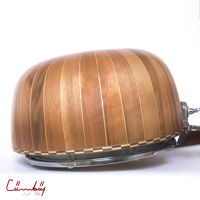

image  964 : yayli tambur


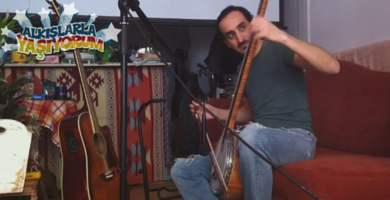

image  959 : yayli tambur


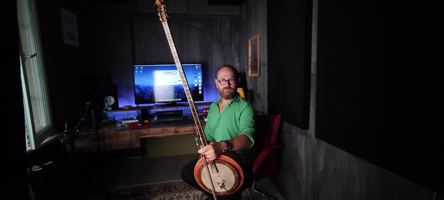

image  907 : yayli tambur


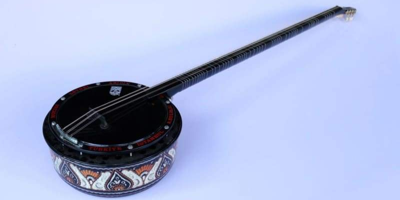

In [70]:
# why are mandolins being classified as kanun?
check_instrument('kanun', 5)
check_instrument('yayli tambur', 10)

image  217 : electric guitar


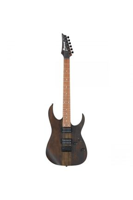

image  216 : electric guitar


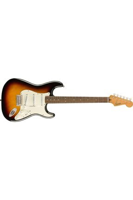

image  221 : electric guitar


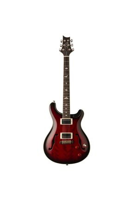

image  256 : electric guitar


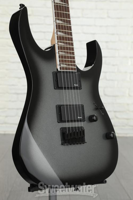

image  226 : electric guitar


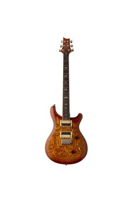

image  304 : acoustic guitar


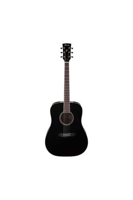

image  331 : acoustic guitar


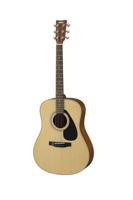

image  374 : acoustic guitar


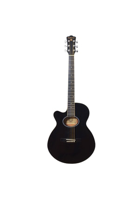

image  394 : acoustic guitar


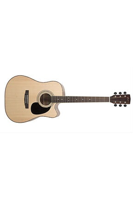

image  330 : acoustic guitar


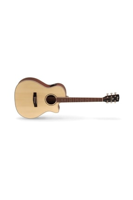

In [63]:
# too many guitars floating in space!
check_instrument('electric guitar', 5)
check_instrument('acoustic guitar', 5)

### Testing the Fine Tuned Model on Unfamiliar Images

In [66]:
# function to download image from URL
def download_image(url):
    headers = {'User-Agent': 'DanLucas (https://github.com/DanLucas1; dan.r.lucas@gmail.com)'}
    
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
    else:
        print(f"Error: Unable to download the image. HTTP status code: {response.status_code}")
    return image

def local_image(path):
    image = Image.open(path)
    return image

# transform to convert PIL image to tensor matching our huggingface data
PIL_transform = v2.Compose([
    v2.ToTensor(), # converts the image to a 0-1 PyTorch tensor
    v2.Lambda(lambda x: x * 255), # scale up to 255, now our PIL image is equivalent to one of the huggingface images
    # copy steps from our main transform function 
    v2.RandomResizedCrop(size=(224, 224), antialias=True), # resize for model requirements
    v2.RandomHorizontalFlip(p=0.5),
    scale_tensor, # converts to [0, 1] float dtype
    v2.Lambda(lambda x: torch.clamp(x, 0, 1)),  # clamp max values to 1 before normalization
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # required normalization for resnet
])

def process_image(image):
    return PIL_transform(image).to(device)

# function to download, transform, and classify the image
def classify_image(image_url):

    if 'http' in image_url:
        # download image
        image_pil = download_image(image_url)
    else:
        image_pil = local_image(image_url)
        
    # convert to PyTorch tensor
    image_tensor = process_image(image_pil).unsqueeze(0).to(device)

    # call the model to classify the image 
    output = model(image_tensor)
    _, predicted = torch.max(output, 1)
    print('Prediction:', label_values[predicted.item()])
    # show the image and prediction
    image_pil = image_pil.resize((max(1, int(image_pil.size[0] * 300 / image_pil.size[1])), 300))
    image_pil.show()
    print('\n')

In [67]:
# URLs of images to test
wikipedia_images =  {
    'Harp' : 'https://upload.wikimedia.org/wikipedia/commons/e/ef/Harpo_Marx_playing_the_harp.jpeg',
    'Bağlama' : 'https://upload.wikimedia.org/wikipedia/commons/0/05/Baglama_turc_manche_long.jpg',
    'Electric Guitar' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/01/Gibson_Les_Paul_54_Custom.jpg/320px-Gibson_Les_Paul_54_Custom.jpg',
    'Acoustic Guitar' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/Gibson_SJ200.jpg/800px-Gibson_SJ200.jpg',
    'Qanun' : 'https://upload.wikimedia.org/wikipedia/commons/1/1a/Q%C4%81n%C5%ABn_-_MET_89.4.330.jpg',
    'Violin' : 'https://upload.wikimedia.org/wikipedia/commons/9/9f/Stainer.jpg',
    'Kemenche' : 'https://upload.wikimedia.org/wikipedia/commons/e/ee/Kemenche0.jpg',
    'Mandolin' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Paris_Swing_Samois_Mandolin_MS-130-SN.jpg/800px-Paris_Swing_Samois_Mandolin_MS-130-SN.jpg',
    'Oud' : 'https://upload.wikimedia.org/wikipedia/commons/8/88/Oud2.jpg',
    'Yaylı tambur' : 'https://upload.wikimedia.org/wikipedia/commons/8/8a/Yayl%C4%B1Tambur_of_DrOzanYarman.jpg'
}

context_images = {
    'Fender Precision Bass' : '/workspace/pbass.jpg',
    'Fender Electric Guitar' : '/workspace/strat.jpg',
    'Jimi Hendrix' : 'https://miro.medium.com/v2/resize:fit:640/format:webp/0*f9ZzyN2ED0wHeVGj.jpg',
    'Martin Acoustic Guitar' : '/workspace/martin.jpg',
    'Johnny Cash' : 'https://www.nme.com/wp-content/uploads/2016/09/SnapGalleries180311.jpg'
}

#### Wikipedia examples for each instrument

Actual: Harp
Prediction: harp


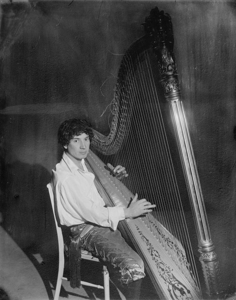



Actual: Bağlama
Prediction: baglama


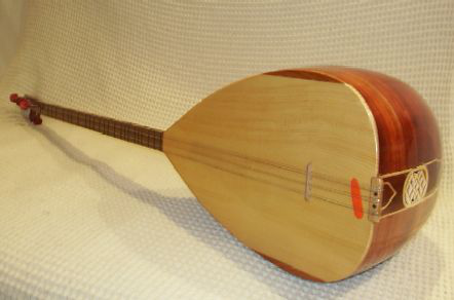



Actual: Electric Guitar
Prediction: electric guitar


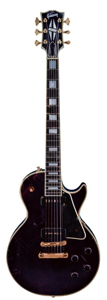



Actual: Acoustic Guitar
Prediction: mandolin


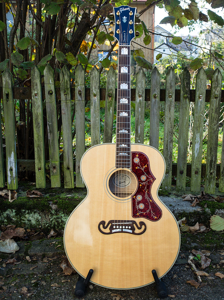



Actual: Qanun
Prediction: kanun


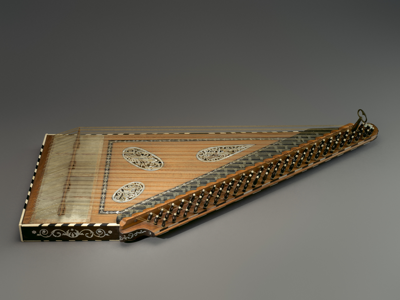



Actual: Violin
Prediction: violin


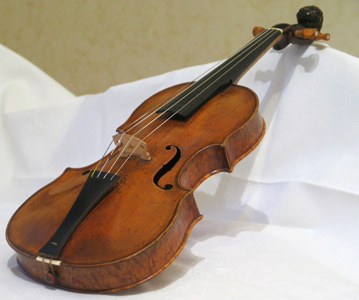



Actual: Kemenche
Prediction: kemence


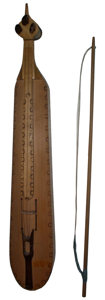



Actual: Mandolin
Prediction: mandolin


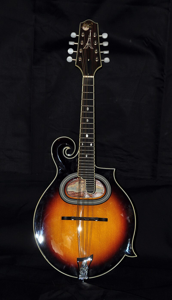



Actual: Oud
Prediction: oud


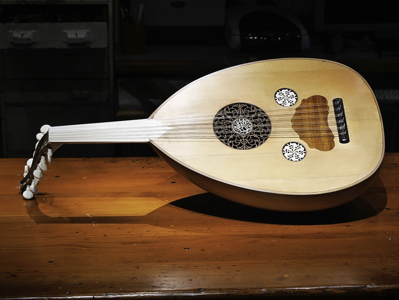



Actual: Yaylı tambur
Prediction: kanun


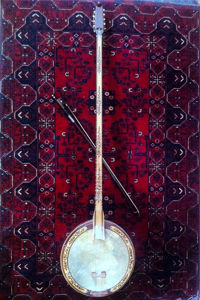

In [68]:
# Loop through images
for img in wikipedia_images:
    print('Actual:', img)
    classify_image(wikipedia_images[img])

#### Mixed context instrument examples

Fender Precision Bass
Prediction: electric guitar


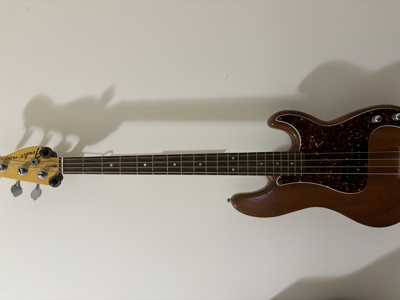



Fender Electric Guitar
Prediction: electric guitar


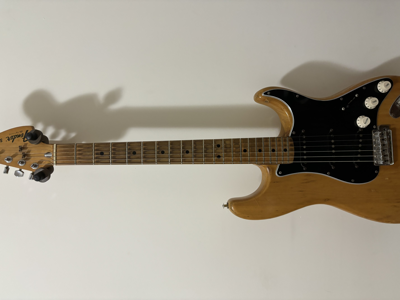



Jimi Hendrix
Prediction: harp


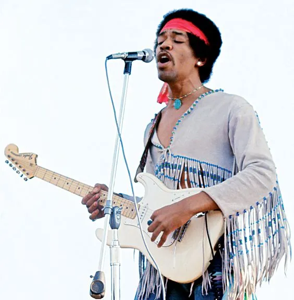



Martin Acoustic Guitar
Prediction: acoustic guitar


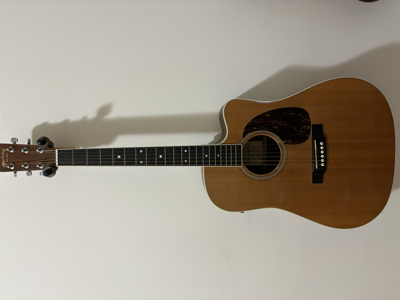



Johnny Cash
Prediction: mandolin


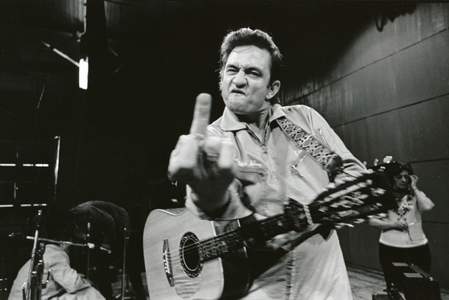

In [69]:
# Loop through images
for img in context_images:
    print(img)
    classify_image(context_images[img])